In [3]:
import numpy as np


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from pytrends.request import TrendReq
import pytz
import warnings
from datetime import datetime

import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from ta.momentum import stochrsi,rsi
from ta.trend import ema_indicator, macd_diff, vortex_indicator_neg, vortex_indicator_pos, adx, cci, sma_indicator
from ta.volatility import bollinger_hband, bollinger_lband
from ta.volume import volume_weighted_average_price


warnings.filterwarnings('ignore')

In [4]:

def addIndicators(df:pd.DataFrame,b_engulfings:bool=False, derivative:bool=False, double_derivative:bool=False) -> pd.DataFrame:
    """Apply indicators to the DataFrame.

    Args:
        df (pd.DataFrame): The dataframe you want to add indicators on.
        b_engulfings (bool, optional): Add bearish and bullish engulfing indicators. Defaults to False.
        derivative (bool, optional): Add the first derivative of the Close price. Defaults to False.
        double_derivative (bool, optional): Add the second derivative of the Close price. Defaults to False.

    Returns:
        pd.DataFrame: The same dataframe with indicators
    """
    def isBearishCandleStick(candle) -> bool:
        """Check whether a candle is a bearish candle or not

        Args:
            candle (pd.Series): The current candle that contains OHLC

        Returns:
            bool: A boolean representing if the candle is bearish candle (True) or not (False)
        """
        return candle['Close']<candle['Open']

    def isBullishCandleStick(candle) -> bool:
        """Check whether a candle is a bullish candle or not

        Args:
            candle (pd.Series): The current candle that contains OHLC

        Returns:
            bool: A boolean representing if the candle is bullish candle (True) or not (False)
        """
        return candle['Close']>candle['Open']

    def isBullishEngulfing(previous_candle,current_candle) -> int:
        """A function that check for bullish engulfing pattern through candle stick

        Args:
            previous_candle (pd.Series): The previous candle that contains OHLC
            current_candle (pd.Series): The current candle that contains OHLC

        Returns:
            int: represent the pattern spotting : 1 bullish engulfing, 0 not.
        """
        return 1 if isBearishCandleStick(previous_candle) and isBullishCandleStick(current_candle) and previous_candle['Open']<current_candle['Close'] and previous_candle['Close']>current_candle['Open'] else 0
        
    def isBearishEngulfing(previous_candle,current_candle) -> int:
        """A function that check for bearish engulfing pattern through candle stick

        Args:
            previous_candle (pd.Series): The previous candle that contains OHLC
            current_candle (pd.Series): The current candle that contains OHLC

        Returns:
            int: represent the pattern spotting : 1 bearish engulfing, 0 not.
        """
        return 1 if isBullishCandleStick(previous_candle) and isBearishCandleStick(current_candle) and previous_candle['Close']<current_candle['Open'] and previous_candle['Open']>current_candle['Close'] else 0    
            
    df['High_Low_diff'] = df.High-df.Low
    df['EMA20'] = ema_indicator(df.Close,20)
    df['EMA50'] = ema_indicator(df.Close,50)
    df['EMA100'] = ema_indicator(df.Close,100)
    df['EMA200'] = ema_indicator(df.Close,200)
    df['MACD'] = macd_diff(df.Close)
    df['Stoch_RSI'] = stochrsi(df.Close, 14, smooth1=3, smooth2=3)
    df['Vortex'] = (vortex_indicator_pos(df.High,df.Low,df.Close,20,fillna=True)-1)-(vortex_indicator_neg(df.High,df.Low,df.Close,20,fillna=True)-1)
    df['Bollinger_low'] = bollinger_hband(df.Close,20,fillna=True)
    df['Bollinger_high'] = bollinger_lband(df.Close,20,fillna=True)
    df['ADX'] = adx(df.High,df.Low,df.Close)
    df['CCI'] = cci(df.High,df.Low,df.Close,14)
    df['OVB'] = (np.sign(df.Close.diff())*df.Volume).fillna(0).cumsum()
    df['OVB_EMA200'] = ema_indicator(df.OVB,200)
    trixLength = 9
    trixSignal = 21
    df['TRIX'] = ema_indicator(ema_indicator(ema_indicator(df['Close'], window=trixLength), window=trixLength), window=trixLength)
    df['TRIX_PCT'] = df["TRIX"].pct_change()*100
    df['TRIX_SIGNAL'] = sma_indicator(df['TRIX_PCT'],trixSignal)
    df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
    #df['EVM'] = ease_of_movement(df.High,df.Low,df.Volume,14)
    if b_engulfings==True:
        df['Bullish_engulfing'] = np.nan
        df['Bullish_engulfing'].iloc[1:] = [isBullishEngulfing(df.iloc[i-1],df.iloc[i]) for i in range(1,len(df))]
        df['Bearish_engulfing'] = np.nan
        df['Bearish_engulfing'].iloc[1:] = [isBearishEngulfing(df.iloc[i-1],df.iloc[i]) for i in range(1,len(df))]
    if derivative==True:
        df['Slope'] = df.Close.diff()
    if double_derivative==True:
        df['Acceleration'] = df.Close.diff().diff()
    return df.dropna()

# Load day data

In [3]:
df = pd.read_csv('../backtest_tools/database/database/Binance/1h/BTC-USDT.csv',names=['Date','Open','High','Low','Close','Volume'])
df = df.iloc[1:]
df['Date'] = df['Date'].apply(lambda x: int(str(x)[:-3]))
df = df.astype(float)
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')

df['join_key'] =  [str(df.index[i].day)+str(df.index[i].month)+str(df.index[i].year) for i in range(len(df))]
df = df.iloc[:-1]
df.head()

,Open,High,Low,Close,Volume,Timestamp,join_key
Date,,,,,,,
2017-08-17 06:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,1502942400,1782017
2017-08-17 07:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,1502946000,1782017
2017-08-17 08:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,1502949600,1782017
2017-08-17 09:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,1502953200,1782017
2017-08-17 10:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,1502956800,1782017


In [4]:
len(df)

42335

# Getting Google Trends data

In [5]:
def addTimestampToDf(df)->pd.DataFrame:
    """add timestamp to dataframe as column

    Args:
        df (pd.DataFrame): The Dataframe we want to add timestamp as col

    Returns:
        pd.DataFrame: The Dataframe with the new column
    """
    df['Timestamp'] = [round(datetime.timestamp(df.index[ind])) for ind in range(len(df.index))]
    df['Timestamp'] = df['Timestamp'].astype(int)
    return df

In [29]:
pytrends = TrendReq(hl='fr-FR', tz=360) 
kw_list = ["BTC","Blockchain","Bitcoin","ETH"] # list of keywords to get data 

pytrends.build_payload(kw_list, cat=0, timeframe='today 12-m') 
data = pytrends.get_historical_interest(kw_list, year_start=df.index[0].year, month_start=df.index[0].month, day_start=df.index[0].day, year_end=df.index[-1].year, month_end=df.index[-1].month, day_end=df.index[-1].day, hour_end=df.index[-1].hour,cat=0, sleep=0,frequency='hourly')
data = addTimestampToDf(data)

data = data.drop_duplicates(subset=['Timestamp'],keep='first')
data

,BTC,Blockchain,Bitcoin,ETH,isPartial,Timestamp
date,,,,,,
2017-08-17 00:00:00,19,6,76,2,False,1502920800
2017-08-17 01:00:00,18,5,83,4,False,1502924400
2017-08-17 02:00:00,21,7,88,5,False,1502928000
2017-08-17 03:00:00,21,5,81,4,False,1502931600
2017-08-17 04:00:00,21,10,85,5,False,1502935200
...,...,...,...,...,...,...
2022-06-21 06:00:00,11,1,37,2,False,1655784000
2022-06-21 07:00:00,11,2,38,2,False,1655787600
2022-06-21 08:00:00,10,2,36,2,False,1655791200


In [30]:
df

,Open,High,Low,Close,Volume,Timestamp,join_key
Date,,,,,,,
2017-08-17 06:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,1502942400,1782017
2017-08-17 07:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,1502946000,1782017
2017-08-17 08:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,1502949600,1782017
2017-08-17 09:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,1502953200,1782017
2017-08-17 10:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,1502956800,1782017
...,...,...,...,...,...,...,...
2022-06-21 06:00:00,20614.04,20740.72,20474.41,20656.17,2925.335420,1655784000,2162022
2022-06-21 07:00:00,20656.17,21029.93,20621.14,20890.77,6516.656110,1655787600,2162022
2022-06-21 08:00:00,20890.77,21202.00,20890.77,21192.08,6114.516620,1655791200,2162022


In [34]:
errors = list(set(df.Timestamp.values) - set(data.Timestamp.values)).sort()
errors_2 = list(set(data.Timestamp.values)-set(df.Timestamp.values)).sort()

In [51]:
print(data[data['Timestamp']==errors_2[-1]])

                     BTC  Blockchain  Bitcoin  ETH  isPartial   Timestamp
date                                                                     
2018-11-14 08:00:00   16           9       38    5      False  1542178800


In [53]:
print(df[df['Timestamp']==errors[-1]])

                         Open     High       Low    Close      Volume  \
Date                                                                    
2021-10-31 02:00:00  62375.28  62405.3  62114.18  62169.0  1695.15085   

                      Timestamp  join_key  
Date                                       
2021-10-31 02:00:00  1635642000  31102021  


In [28]:
pytrends = TrendReq(hl='fr-FR', tz=360) 
kw_list = ["BTC","Blockchain","Bitcoin","ETH"] # list of keywords to get data 

pytrends.build_payload(kw_list, cat=0, timeframe='today 12-m') 
data = pytrends.get_historical_interest(kw_list, year_start=df.index[0].year, month_start=df.index[0].month, day_start=df.index[0].day, year_end=df.index[-1].year, month_end=df.index[-1].month, day_end=df.index[-1].day, cat=0, sleep=0,frequency='daily')
data = addTimestampToDf(data)

data = data.drop_duplicates(subset=['Timestamp'],keep='first')
#data = data.reset_index() 
#data.set_index('date',inplace=True)
#data.BTC = data.BTC + data.Bitcoin
#
#window=20
#
#data[f'BTC_SMA{window}'] =  data.BTC.rolling(window).mean()
#data[f'Blockchain_SMA{window}'] =  data.Blockchain.rolling(window).mean()
#data[f'ETH_SMA{window}'] =  data.Blockchain.rolling(window).mean()
#data.drop(columns=['Bitcoin','isPartial'],inplace=True)
#data.dropna(inplace=True)

print(f'Total records {len(data)}')
data.head()

Total records 1770


,BTC,Blockchain,Bitcoin,ETH,isPartial,Timestamp
date,,,,,,
2017-08-17,2,1,11,1,False,1502920800
2017-08-18,2,1,11,1,False,1503007200
2017-08-19,2,1,10,0,False,1503093600
2017-08-20,2,1,9,0,False,1503180000
2017-08-21,2,1,10,1,False,1503266400


# Getting Fear and Greed Data

In [5]:
import requests
import json
response_fng = requests.get('https://api.alternative.me/fng/?limit=0&format=json').text
df_fng = pd.DataFrame(json.loads(response_fng)['data'])
df_fng.drop(columns=['time_until_update'],inplace=True)
df_fng.rename(columns={'timestamp':'date'},inplace=True)
df_fng['date'] = df_fng['date'].astype(int).apply(lambda x: datetime.fromtimestamp(x))
df_fng.sort_values('date',inplace=True)
df_fng.set_index('date',inplace=True)
df_fng= df_fng.iloc[:-2]
df_fng['join_key'] =  [str(df_fng.index[i].day)+str(df_fng.index[i].month)+str(df_fng.index[i].year) for i in range(len(df_fng))]
print(f'{len(df_fng)} total records')
df_fng.head()

1613 total records


,value,value_classification,join_key
date,,,
2018-02-01 01:00:00,30,Fear,122018
2018-02-02 01:00:00,15,Extreme Fear,222018
2018-02-03 01:00:00,40,Fear,322018
2018-02-04 01:00:00,24,Extreme Fear,422018
2018-02-05 01:00:00,11,Extreme Fear,522018


# Adding Google Trends and Fear & Greed to df

In [78]:
df['BTC_trends'] = data.BTC.values+data.Bitcoin.values
df = df.iloc[168:]
for i in list(set(df.join_key.values) - set(df_fng.join_key.values)):
    df.drop(df.loc[df['join_key']==i].index, inplace=True)
df['Fear_value'] = df_fng.value.values
df['Fear_class'] = df_fng.value_classification.values

df['Fear_SMA']=df.Fear_value.rolling(20).mean()
df['BTC_trends_SMA']=df.BTC_trends.rolling(20).mean()
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Volume,Timestamp,join_key,BTC_trends,Fear_value,Fear_class,Fear_SMA,BTC_trends_SMA
Date,,,,,,,,,,,,
2018-02-20 01:00:00,11147.11,11786.01,11100.59,11200.99,48153.354288,1519084800,2022018,20,74,Greed,43.55,26.75
2018-02-21 01:00:00,11195.07,11304.03,10200.00,10437.60,68113.818754,1519171200,2122018,20,54,Neutral,44.75,26.15
2018-02-22 01:00:00,10439.02,10933.44,9679.00,9811.04,67060.166483,1519257600,2222018,18,44,Fear,46.20,24.90
2018-02-23 01:00:00,9815.55,10435.00,9570.19,10131.04,57202.702370,1519344000,2322018,16,39,Fear,46.15,24.25
2018-02-24 01:00:00,10131.04,10496.97,9352.00,9694.51,40888.156299,1519430400,2422018,14,31,Fear,46.50,23.70


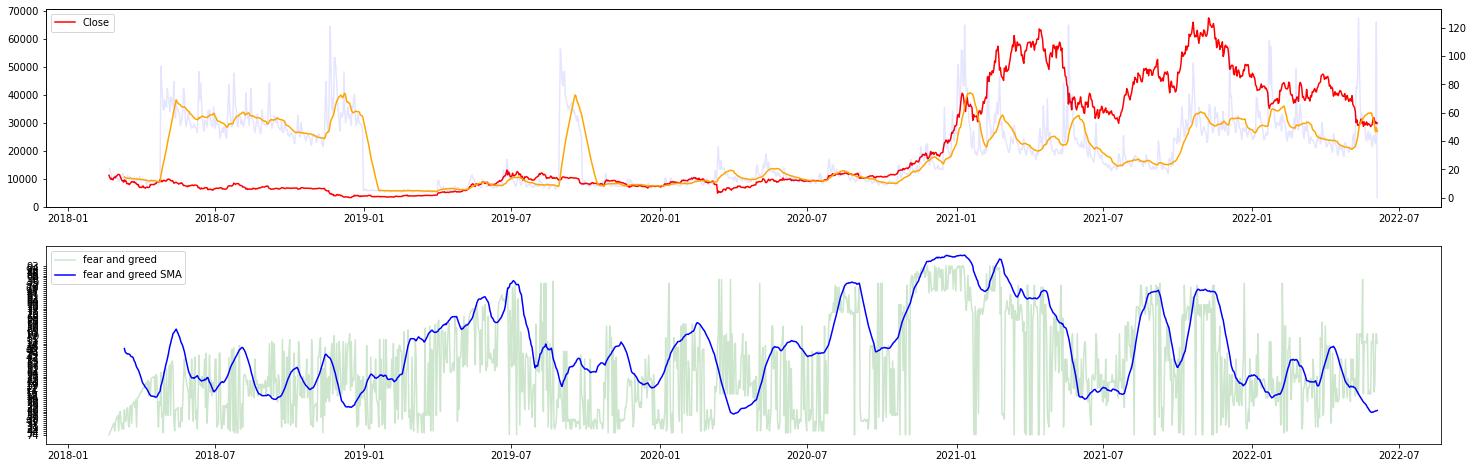

In [79]:
fig, ax_left = plt.subplots(2, figsize=(25,8))

ax_left[0].plot(df.Close, color='red',label='Close')
ax = ax_left[0].twinx()
ax.plot(df.BTC_trends,color='blue',alpha=0.1,label='BTC trend')
ax.plot(df.BTC_trends.rolling(20).mean(),color='orange',label='BTC trend SMA')

ax_left[0].legend(loc="upper left")



ax_left[1].plot(df['Fear_value'],alpha=0.2 ,color='green',label='fear and greed')
ax_left[1].plot(df.Fear_value.rolling(20).mean(), color='blue',label='fear and greed SMA')
#ax_left[1].axhline(y=0, color='black', linestyle='--')
ax_left[1].legend(loc="upper left")#



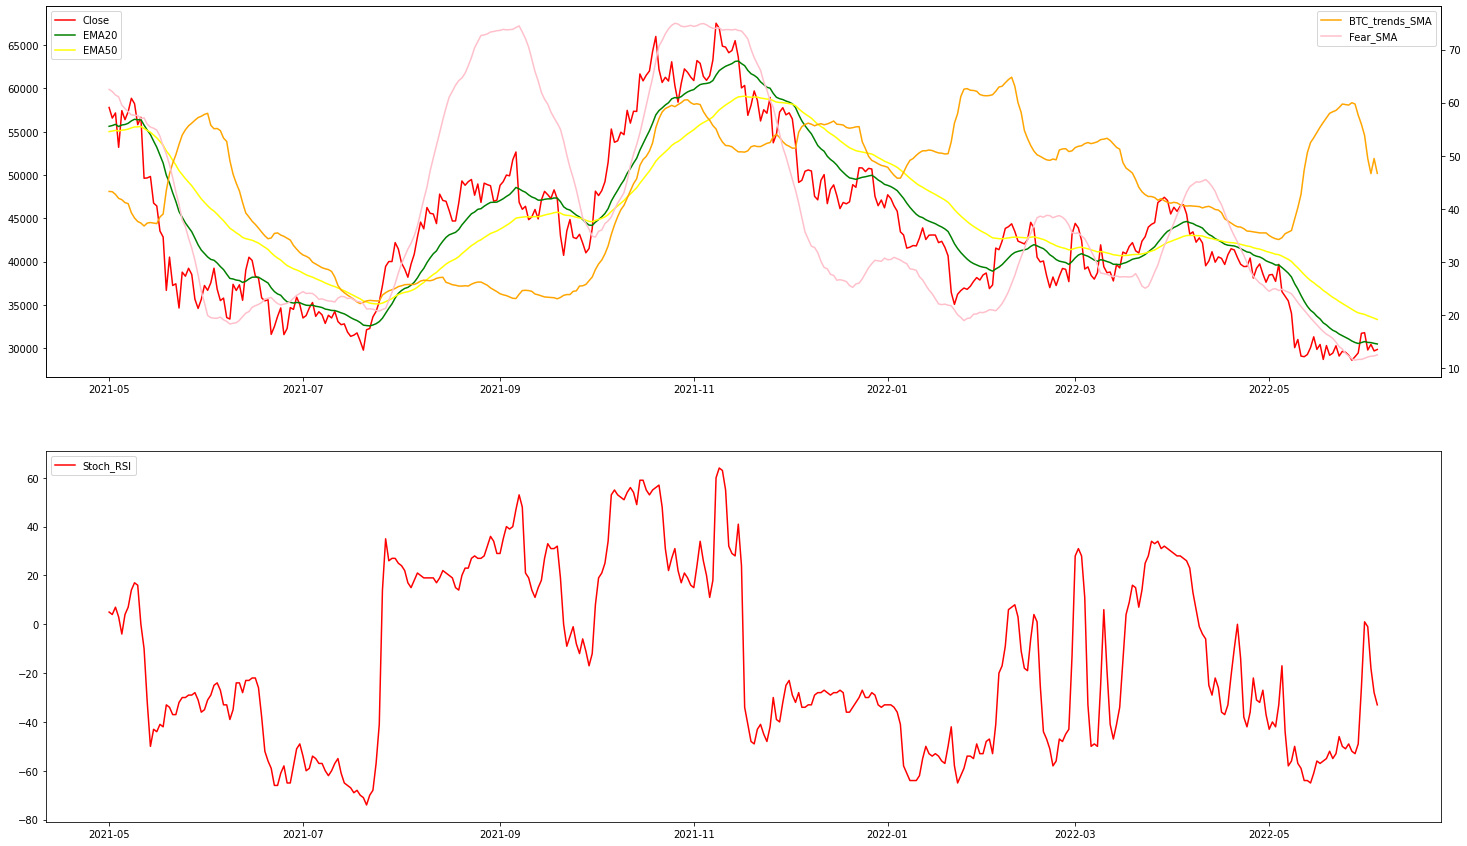

In [88]:
fig, ax_left = plt.subplots(2, figsize=(25,15))

window_to_see = 400

ax_left[0].plot(df.Close[-window_to_see:], color='red',label='Close')
ax_left[0].plot(df.EMA20[-window_to_see:], color='green',label='EMA20')
ax_left[0].plot(df.EMA50[-window_to_see:], color='yellow',label='EMA50')
#ax_left.plot(df.Pred_close[-window_to_see:], color='blue',label='Close pred')
ax = ax_left[0].twinx()
ax.plot(df.BTC_trends_SMA.iloc[-window_to_see:], color='orange',label='BTC_trends_SMA')
ax.plot(df.Fear_SMA.iloc[-window_to_see:], color='pink',label='Fear_SMA')
#ax.axhline(y=0, color='black', linestyle='--')
ax_left[0].legend(loc="upper left")#
ax.legend(loc="upper right")#

ax_left[1].plot(df.Stoch_RSI.rolling(100).mean().iloc[-window_to_see:], color='blue',label='Stoch_RSI EMA200')
ax_left[1].axhline(y=0.2, color='black', linestyle='--')
ax_left[1].axhline(y=0.5, color='black', linestyle='--')
ax_left[1].axhline(y=0.8, color='black', linestyle='--')
ax_left[1].legend(loc="upper left")#
